### Train Logistic Regression

- Joel Stremmel
- 04-17-23

##### About

Train Logistic Regression on the formatted data using K-Fold Cross-Validation and save the scores.

##### Imports

In [1]:
import os
import re
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

##### Set Parameters

In [2]:
ngram_range = (2, 4)
min_df = 5
max_df = 0.9
sublinear_tf = True
C = 0.1
seed = 42
max_iter = 5000
penalty = "l2"
solver = 'saga'

##### Load Formatted Data

In [3]:
with open('data/X_folds.pkl', 'rb') as f:
    X_folds = pickle.load(f)

with open('data/y_folds.pkl', 'rb') as f:
    y_folds = pickle.load(f)

##### Check Data Shape

In [4]:
assert len(X_folds) == len(y_folds), "Expected the same number of folds in X and y."
X = list(X_folds.values())
y = list(y_folds.values())

##### Check Target Prevalence

In [5]:
print(f"Target prevalance: {np.mean(np.concatenate(y))}.")

Target prevalance: 0.4931506849315068.


##### Vectorize Text and Fit Model to Each Fold

In [6]:
y_probs, y_trues = [], []
for i in range(len(X)):
    
    print(f"Fitting model using fold {i} as out of fold data.")
    
    # Define TFIDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        sublinear_tf=sublinear_tf,
        strip_accents="unicode",
        analyzer="word",
        token_pattern=r"(?u)\b\w\w+\b",
        stop_words="english",
        ngram_range=ngram_range,
        norm="l2",
        min_df=min_df,
        max_df=max_df,
        smooth_idf=False,
        lowercase=True
    )

    # Identify train folds and shuffle samples
    X_train, y_train = np.concatenate(X[0:i] + X[i+1:], axis=0), np.concatenate(y[0:i] + y[i+1:], axis=0)
    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    X_train, y_train = X_train[indices], y_train[indices]
    
    # Identify test folds
    X_test, y_test = X[i], y[i]
    
    # Vectorize text
    train_features = tfidf_vectorizer.fit_transform(X_train)
    test_features = tfidf_vectorizer.transform(X_test)
    
    # Define and fit model
    lr = LogisticRegression(
        solver=solver,
        fit_intercept=True,
        max_iter=max_iter,
        penalty=penalty,
        C=C,
        class_weight=None,
        random_state=seed
    )
    lr.fit(train_features, y_train)
    
    # Predict on test folds and save labels and scores
    y_prob = lr.predict_proba(test_features)[:, 1]
    y_probs.append(y_prob)
    y_trues.append(y_test)

Fitting model using fold 0 as out of fold data.
Fitting model using fold 1 as out of fold data.
Fitting model using fold 2 as out of fold data.
Fitting model using fold 3 as out of fold data.
Fitting model using fold 4 as out of fold data.


##### Save Model Probabilities on Test Folds and True Labels

In [7]:
with open('results/lr_y_trues.pkl', 'wb') as f:
    pickle.dump(y_trues, f)

with open('results/lr_y_probs.pkl', 'wb') as f:
    pickle.dump(y_probs, f)

##### Fit a Model to All of the Data

In [8]:
X_train, y_train = np.concatenate(X, axis=0), np.concatenate(y, axis=0)
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train, y_train = X_train[indices], y_train[indices]

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=sublinear_tf,
    strip_accents="unicode",
    analyzer="word",
    token_pattern=r"(?u)\b\w\w+\b",
    stop_words="english",
    ngram_range=ngram_range,
    norm="l2",
    min_df=min_df,
    max_df=max_df,
    smooth_idf=False,
    lowercase=True
)

train_features = tfidf_vectorizer.fit_transform(X_train)

lr = LogisticRegression(
    solver=solver,
    fit_intercept=True,
    max_iter=max_iter,
    penalty=penalty,
    class_weight=None,
    random_state=seed
)

lr = lr.fit(train_features, y_train)

##### Define a Function to Plot the LR Model Coefficients

In [9]:
def plot_coefs(clf, features, top_n=10, x_size=12, y_size=12):
    """
    Plot top N coefficients by absolute value in descending order
    """

    features_and_intercept = np.concatenate((features, ['intercept']), axis=0)
    coefficients = np.concatenate((clf.coef_[0], clf.intercept_), axis=0)

    indices = (-np.abs(coefficients)).argsort()
    top_coefs = coefficients[indices][0: top_n].tolist()
    top_feats = features_and_intercept[indices][0: top_n].tolist()
    
    top_coefs.reverse()
    top_feats.reverse()

    plt.clf()
    plt.figure(figsize=(x_size, y_size))

    plt.title('Logistic Regression Coefficients')
    plt.barh(range(len(top_coefs)), top_coefs, color='navy', align='center')
    plt.yticks(range(len(top_coefs)), top_feats)
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.axvline(x=0, color='red', linestyle='--')

    plt.show()

##### Plot Coefficients

<Figure size 640x480 with 0 Axes>

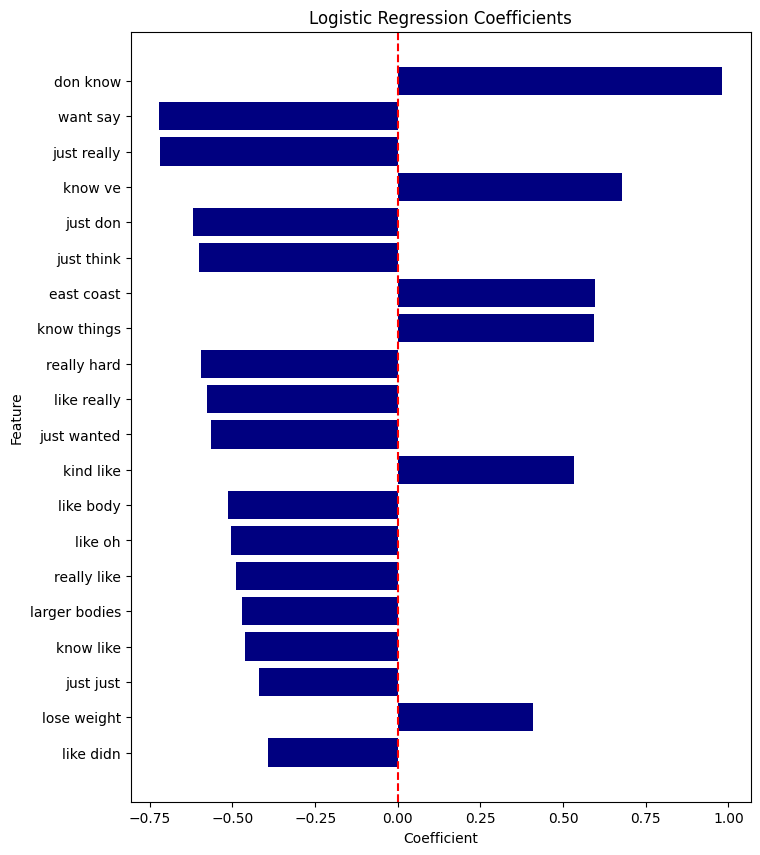

In [10]:
plot_coefs(
    lr,
    tfidf_vectorizer.get_feature_names_out(),
    top_n=20,
    x_size=8,
    y_size=10
)